In [1]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import cbc, numpy as np, scipy as sp, matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
waist = 1.2e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 100, 100, 1
detNx, detNy = 128, 128
pix_size = 55e-3
det_dist = 30

# Gaussian beam

In [3]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def R(zs, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    return zs + zr**2 / zs

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

def gaussian(xs, ys, zs, waist=1e-4, wavelength=1.5e-7):
    k = 2 * np.pi / wavelength
    zr = np.pi * waist**2 / wavelength
    Rs = zs + zr**2 / zs
    wz = waist * sqrt(1 + z**2 / zr**2)
    return np.pi**-1 * waist**-1 * wz**-1 * np.exp(-(xs**2 + ys**2) / wz**2) * np.exp(-1j * (k * z - np.arctan(zs / zr) + k * (xs**2 + ys**2) / 2 / Rs))

In [4]:
zR(waist, wavelength)

3.0159289474462013e-05

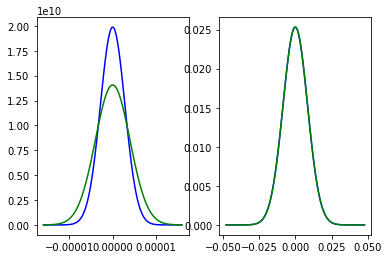

In [50]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
us2 = np.abs(cbc.gaussian(xs, 0, zR(waist, wavelength), waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
ufs2 = np.abs(cbc.gaussian_f(kxs, 0, zR(waist, wavelength), waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us, 'b-', xs, us2, 'g-')
ax2.plot(kxs, ufs, 'b-', kxs, ufs2, 'g-')
plt.show()

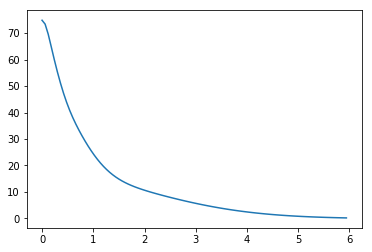

In [32]:
%matplotlib inline
ss = np.linspace(0, 6.0, 100, endpoint=False)
asfs = cbc.asf_vals(ss, cbc.asf_coeffs())
plt.plot(ss, asfs)
plt.show()

In [33]:
def normal(x, mu, sigma):
    return (np.pi * sigma**2)**-0.5 * np.exp(-(x - mu)**2 / sigma**2)

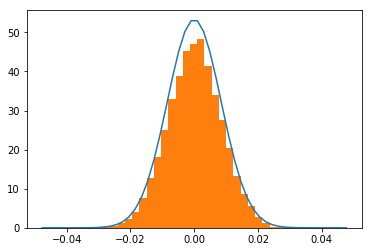

In [34]:
%matplotlib inline
knum = 10000
ks = cbc.gaussian_dist(knum, 0, waist, wavelength)
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength))
us = np.abs(cbc.gaussian_f(kxs, 0, 10, waist, wavelength)) * 4 * np.pi / thdiv(waist, wavelength)*2
plt.plot(kxs, us)
plt.hist(ks[:,0], 30, density=True)
plt.show()

In [35]:
knum = 1000
z = 0
ks = cbc.gaussian_dist(knum, z, waist, wavelength)[:, 0:2]
thdiv(waist,wavelength) * np.pi**0.5 / (2 * np.pi)**2 * cbc.gaussian_f(ks, z, waist, wavelength).sum() / knum

(-5.4075207852767305e-06+9.416457661845481e-06j)

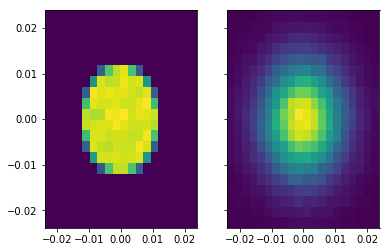

In [17]:
%matplotlib inline
_thdiv = thdiv(waist,wavelength)
kxs, kys = cbc.uniform_dist(100000, waist, wavelength)[:, 0:2].T
kxs2, kys2 = cbc.gaussian_dist(100000, waist, wavelength)[:, 0:2].T
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.hist2d(kxs, kys, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
ax2.hist2d(kxs2, kys2, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
plt.show()

# Convolution approximation

In [36]:
def gaus_dist(kxs, kys, waist, wavelength):
    thdiv = wavelength / np.pi / waist
    return np.pi**-1 * thdiv**-2 * np.exp(-(kxs**2 + kys**2) / thdiv**2)

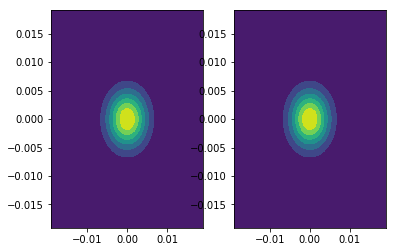

In [37]:
%matplotlib inline
knum = 100000
mus = np.zeros(2)
sigma = thdiv(waist, wavelength)
cov = [[sigma**2 / 2, 0], [0, sigma**2 / 2]]
rv = sp.stats.multivariate_normal(mean=mus, cov=cov)
_kxs = np.linspace(-4 * sigma, 4 * sigma)
kxs, kys = np.meshgrid(_kxs, _kxs)
ks = np.empty(kxs.shape + (2,))
ks[:, :, 0] = kxs; ks[:, :, 1] = kys
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.contourf(kxs, kys, gaus_dist(kxs, kys, waist, wavelength))
ax2.contourf(kxs, kys, rv.pdf(ks))

In [38]:
ks1 = np.random.multivariate_normal(mus, cov, knum)
ks2 = cbc.gaussian_dist(knum, 0, waist, wavelength)[:, 0:2]
print(
    thdiv(waist, wavelength),
    np.sqrt((ks1**2).sum(axis=-1)).sum(axis=-1) / knum * 2 / np.sqrt(np.pi),
    np.sqrt((ks2**2).sum(axis=-1)).sum(axis=-1) / knum * 2 / np.sqrt(np.pi),
sep='\n')

0.00477464829275686
0.0047757909214702346
0.004781154677600312


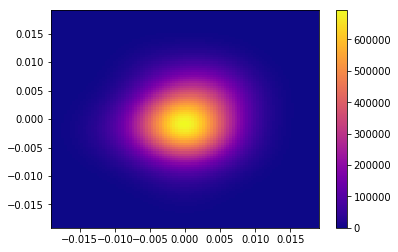

In [39]:
%matplotlib inline
knum = 100
_ks = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
kxs, kys = np.meshgrid(_ks, _ks)
ks = np.empty(kxs.shape + (2,))
ks[:,:,0] = kxs; ks[:,:,1] = kys
qs = np.random.multivariate_normal(mus, cov, knum)[np.newaxis,np.newaxis,:] - ks[:,:,np.newaxis]
fs = rv.pdf(qs).sum(axis=-1)
plt.pcolor(kxs, kys, fs, cmap=cm.plasma, vmin=0.0, vmax=fs.max())
plt.colorbar()
plt.show()

In [70]:
x, y, z = cbc.lattice(a, b, c, 2, 2, 1, lat_orig=[0,0,zR(waist, wavelength)])
x_det = np.arange((-detNx + 1) / 2.0, (detNx + 1) / 2.0) * pix_size
y_det = np.arange((-detNy + 1) / 2.0, (detNy + 1) / 2.0) * pix_size
z_det = det_dist
xdets, ydets, zdets = map(np.ravel, np.meshgrid(x_det, y_det, z_det))
XS, YS, ZS = np.subtract.outer(xdets, x), np.subtract.outer(ydets, y), np.subtract.outer(zdets, z)
RS = np.sqrt(XS**2 + YS**2 + ZS**2)

In [7]:
%matplotlib inline
x, y, z = cbc.lattice(a, b, c, Nx, Ny, Nz, lat_orig=[0,0,zR(waist, wavelength)])
asf_coeffs = cbc.asf_coeffs()
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(x, y, z, waist, wavelength)

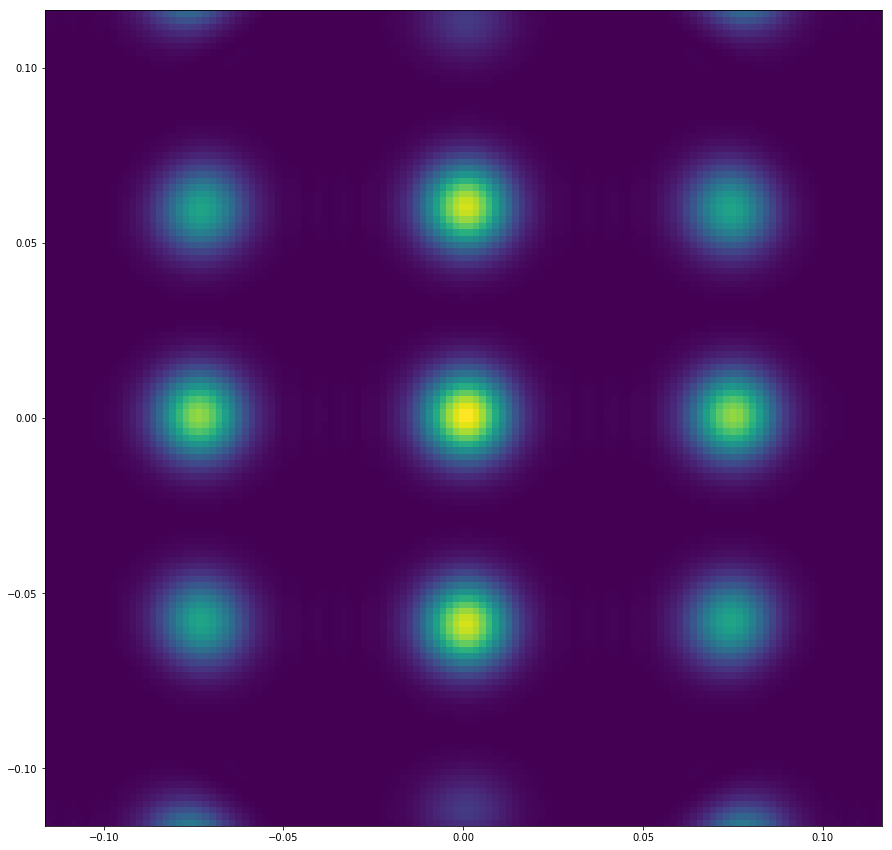

In [8]:
us = cbc.gaussian(x, y, z, waist, wavelength)
qabs = cbc.utils.q_abs(kouts, kins) / 2.0 / wavelength / 1e7
asfs = cbc.asf_vals(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, x, y, z, wavelength)
res = (asfs * us * phs).sum(axis=-1).reshape(kxs.shape)
ints = np.abs(res)
f, ax = plt.subplots(figsize=(15, 15))
ax.pcolor(kxs, kys, ints, cmap=cm.viridis, vmin=ints.min(), vmax=ints.max())
plt.show()

In [ ]:
knum = 1000
%time kjs = cbc.gaussian_dist(knum, z[0], waist, wavelength)
%time kjs = cbc.kout_parax(kjs[:,0], kjs[:,1])
%time qabs = cbc.utils.q_abs(kouts, kjs) / 2.0 / wavelength / 1e7
%time asfs = cbc.asf_vals(qabs, asf_coeffs)
%time phs = cbc.utils.phase_conv(kouts, kjs, x, y, z, wavelength)
%time res = phs.sum(axis=-2) * asfs
print(asfs.shape, phs.shape, res.shape)

CPU times: user 631 µs, sys: 123 µs, total: 754 µs
Wall time: 586 µs
CPU times: user 297 µs, sys: 201 µs, total: 498 µs
Wall time: 391 µs
CPU times: user 203 ms, sys: 84.2 ms, total: 287 ms
Wall time: 285 ms
CPU times: user 797 ms, sys: 42.9 ms, total: 840 ms
Wall time: 838 ms
CPU times: user 1min 19s, sys: 16.8 s, total: 1min 36s
Wall time: 1min 55s


In [ ]:
pts = np.vstack((x,y,z))
phis = np.exp(-2j * np.pi / wavelength * np.einsum('ij,ji->i', kins, pts))
ints2 = np.abs(res.sum(axis=-1)).reshape(kxs.shape) / knum
f, ax = plt.subplots(figsize=(15, 15))
ax.pcolor(kxs, kys, ints2, cmap=cm.viridis, vmin=ints2.min(), vmax=ints2.max())
plt.show()

# Diffraction simulation based on Henry's equations

In [3]:
waist = 1e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 128, 128
pix_size = 55e-3 
det_dist = 30

In [4]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs = np.repeat(2 * zR(waist, wavelength), Nx * Ny)
xs -= 0.25 * a
ys -= 0.501 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.bessel_kins(xs, ys, zs, waist, wavelength)
us = cbc.bessel(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
# kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
# us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)

NameError: name 'zR' is not defined

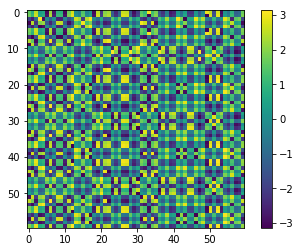

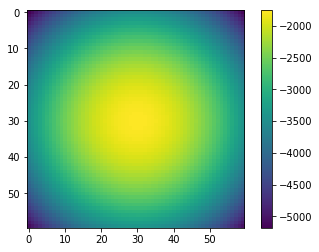

In [75]:
phin = cbc.utils.phase_inc(kins, xs, ys, zs, wavelength).reshape((Nx, Ny))
angs2 = np.angle(phin)
Rs = R(zs, waist, wavelength)
angs3 = (-2 * np.pi / wavelength * ((xs**2 + ys**2) / Rs + (1 - (xs**2 + ys**2) / 2 / Rs**2) * zs)).reshape(Nx, Ny)
plt.imshow(angs2)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()

In [80]:
qs_abs = cbc.utils.q_abs(kouts, kins) / 2.0 / wavelength / 1e7
asf_coeffs1 = cbc.asf_coeffs()
asfs1 = cbc.asf_vals(qs_abs, asf_coeffs1)

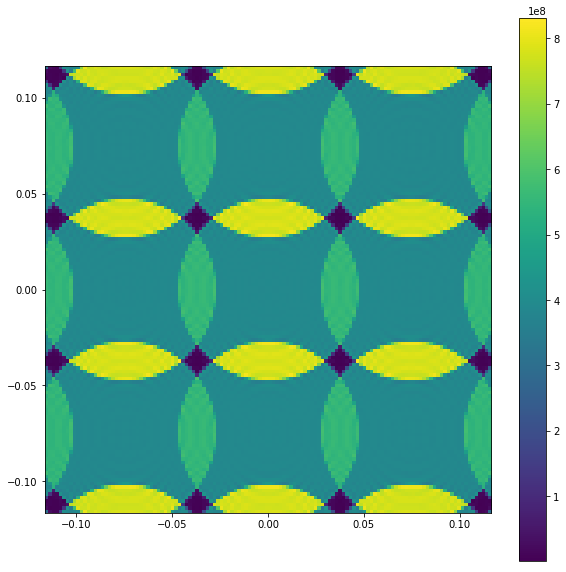

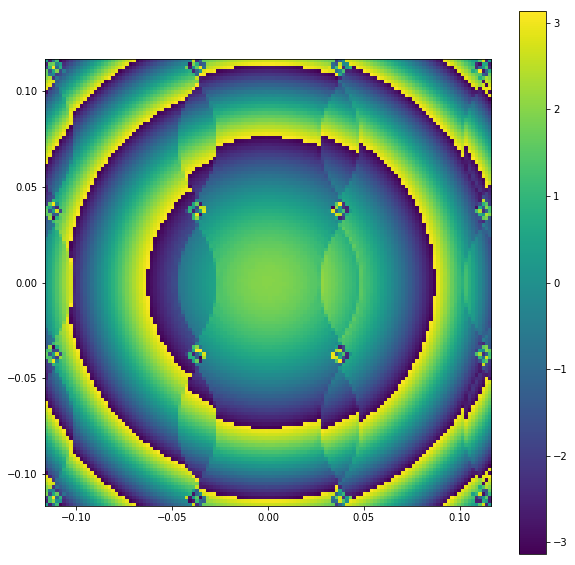

In [81]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=-1).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

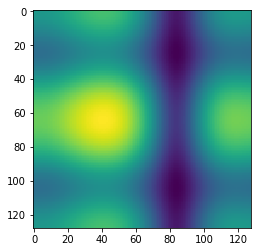

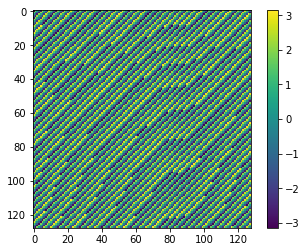

In [78]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()

In [51]:
x0 = 2e-6
asf_coeffs2 = cbc.asf_coeffs('Ag')
asfs2 = cbc.asf_vals(qs_abs, asf_coeffs2)
asfs = asfs1 + np.exp(2j * np.pi / wavelength * qs[:,:,0] * x0) * asfs2
print(asfs.shape)

CPU times: user 299 ms, sys: 147 ms, total: 446 ms
Wall time: 448 ms
CPU times: user 228 ms, sys: 234 ms, total: 462 ms
Wall time: 463 ms
CPU times: user 1.15 s, sys: 203 ms, total: 1.36 s
Wall time: 1.37 s
CPU times: user 1.17 s, sys: 167 ms, total: 1.33 s
Wall time: 1.35 s
(16384, 1600)


# PDB structure factor

In [15]:
xs, ys, zs, bs, els = [], [], [], [], []
for line in open('../cbc/utils/pdb/4et8.pdb'):
    if line.startswith("ATOM"):
            xs.append(float(line[31:38]))
            ys.append(float(line[39:46]))
            zs.append(float(line[47:54]))
            bs.append(float(line[61:66]))
            els.append(line[77:78])
asf_coeffs = np.array([cbc.asf_coeffs(el, wavelength) for el in els])
xs = np.array(xs); ys = np.array(ys); zs = np.array(zs); bs = np.array(bs)

@njit(complex128[:](float64[:,:], float64[:,:], float64[:,:], float64[:], float64[:], float64[:], float64[:]), fastmath=True)
def sf_sum(ss, acoeffs, bcoeffs, xs, ys, zs, bs):
    a = ss.shape[0]
    b, c = acoeffs.shape
    sfs = np.empty(a, dtype=np.complex128)
    ss = np.ascontiguousarray(ss)
    acoeffs = np.ascontiguousarray(acoeffs)
    bcoeffs = np.ascontiguousarray(bcoeffs)
    for i in range(a):
        dsf = 0.0j
        sabs = ss[i,0]**2 + ss[i,1]**2 + ss[i,2]**2
        for j in range(b):
            dasf = 0.0
            ph = 4 * pi * (ss[i,0] * xs[j] + ss[i,1] * ys[j] + ss[i,2] * zs[j])
            for k in range(c):
                dasf += acoeffs[j,k] * exp(-sabs * bcoeffs[j,k])
            dsf += dasf * (cos(ph) + 1j * sin(ph)) * exp(-bs[j] * sabs)
        sfs[i] = dsf
    return sfs

def sf(ss, asf_coeffs, xs, ys, zs, bs):
    acoeffs, bcoeffs = asf_coeffs[:, :5], asf_coeffs[:, 6:]
    return sf_sum(ss.reshape(-1, ss.shape[-1]), acoeffs, bcoeffs, xs, ys, zs, bs).reshape(ss.shape[:-1])

ss1 = np.ones((10, 10, 3)) / sqrt(3)
ss2 = np.ones((10, 10))
asf_cs = cbc.asf_coeffs()
%timeit sf(ss1, asf_coeffs, xs, ys, zs, bs)
%timeit cbc.asf_vals(ss2, asf_cs)
%timeit cbc.sf_vals(ss1, asf_coeffs, xs, ys, zs, bs)
sf1 = sf(ss1, asf_coeffs, xs, ys, zs, bs)
print(sf1[0])

7.87 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.5 µs ± 69 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.22 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[-4.12923451e-07+1.1717515e-06j -4.12923451e-07+1.1717515e-06j
 -4.12923451e-07+1.1717515e-06j -4.12923451e-07+1.1717515e-06j
 -4.12923451e-07+1.1717515e-06j -4.12923451e-07+1.1717515e-06j
 -4.12923451e-07+1.1717515e-06j -4.12923451e-07+1.1717515e-06j
 -4.12923451e-07+1.1717515e-06j -4.12923451e-07+1.1717515e-06j]


# Lens beam

In [2]:
from numba.extending import get_cython_function_address
from numba import njit, cfunc, carray, vectorize
from numba.types import float64, complex128, intc, CPointer, UniTuple
from math import cos, sin, pi, sqrt, exp
import ctypes, scipy.integrate as si
from scipy import LowLevelCallable, special

In [3]:
wavelength = 1.5e-7
f, ap, defoc = 2, 8e-2, 1e-4
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 64, 64
pix_size = 55e-3 / 2
det_dist = 30

In [4]:
addr = get_cython_function_address("scipy.special.cython_special", "j0")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j0 = functype(addr)


@vectorize('float64(float64)')
def j0_vec(x):
    return j0(x)

@njit
def j0_in_njit(x):
    return j0_vec(x)

def jit_integrand(func):
    jit_func = njit(func)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapper(n, args):
        return jit_func(args[0], args[1], args[2], args[3], args[4])
    return LowLevelCallable(wrapper.ctypes)

def quad_complex(func_re, func_im, a, b, **args):
    re = si.quad(func_re, a, b, **args)[0]
    im = si.quad(func_im, a, b, **args)[0]
    return re + 1j * im

@jit_integrand
def rect_re(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return cos(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

@jit_integrand
def rect_im(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return -sin(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

@jit_integrand
def circ_re(rr, r, z, f, wavelength):
    k = 2 * np.pi / wavelength
    return cos(k * rr**2 / 2 * (1 / f - 1 / z)) * j0_in_njit(k * r * rr / z) * 2 * pi * rr

@jit_integrand
def circ_im(rr, r, z, f, wavelength):
    k = 2 * np.pi / wavelength
    return -sin(k * rr**2 / 2 * (1 / f - 1 / z)) * j0_in_njit(k * r * rr / z) * 2 * pi * rr

@jit_integrand
def drect_re(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return (x - xx) * cos(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

@jit_integrand
def drect_im(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return (xx - x) * sin(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

def drbeam(xs, ys, zs, f, a, wavelength):
    dxvals = np.array([quad_complex(drect_re, drect_im, -a, a, args=(x, z + f, f, wavelength), limit=10000) for x, z in zip(xs, zs)])
    dyvals = np.array([quad_complex(drect_re, drect_im, -a, a, args=(y, z + f, f, wavelength), limit=10000) for y, z in zip(ys, zs)])
    xvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(x, z + f, f, wavelength), limit=10000) for x, z in zip(xs, zs)])
    yvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(y, z + f, f, wavelength), limit=10000) for y, z in zip(ys, zs)])
    return (dxvals / xvals / zs , dyvals / yvals / zs)

def rbeam(xs, ys, zs, f, a, wavelength):
    k = 2 * np.pi / wavelength
    coeffs = -1j * np.exp(1j * k * (zs + f)) / wavelength / (zs + f) * np.exp(1j * k / 2 / (zs + f) * (xs**2 + ys**2))
    xvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(x, z + f, f, wavelength), limit=10000) for x, z in zip(xs, zs)])
    yvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(y, z + f, f, wavelength), limit=10000) for y, z in zip(ys, zs)])
    return coeffs * xvals * yvals

def cbeam(xs, ys, zs, f, a, wavelength):
    k = 2 * np.pi / wavelength
    coeffs = -1j * np.exp(1j * k * (zs + f)) / wavelength / (zs + f) * np.exp(1j * k * (xs**2 + ys**2) / 2.0 / (zs + f))
    rvals = np.array([quad_complex(circ_re, circ_im, 0, a, args=(sqrt(x**2 + y**2), z + f, f, wavelength), limit=10000) for x, y, z in zip(xs, ys, zs)])
    return coeffs * rvals

def simpsons(grid, dx):
    simv = np.empty(grid.shape[-1], dtype=np.float64)
    simv[[0,-1]] = 1.0
    simv[1:-1:2] = 4.0
    simv[2:-1:2] = 2.0
    print(simv)
    return dx / 3 * (simv * grid).sum(axis=-1)

def simpsons2d(grid, dx, dy):
    simv = np.empty(grid.shape[-1], dtype=np.float64)
    simv[[0,-1]] = 1.0
    simv[1:-1:2] = 4.0
    simv[2:-1:2] = 2.0
    simm = simv[:, np.newaxis] * simv
    return dx * dy / 9.0 * (simm * grid).sum(axis=(-2,-1))

In [161]:
x0 = np.array([2e-5]); y0 = np.array([2e-5]); z0 = np.array([0.1])
drbeam(x0, y0, z0, f, ap, wavelength)

(array([0.00245514-0.00343326j]), array([0.00245514-0.00343326j]))

In [5]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs = np.repeat(1e-2, Nx * Ny)
xs -= 0.501 * a
ys -= 0.501 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
Rs = np.sqrt(xs**2 + ys**2 + zs**2)
kins = np.dstack((xs / Rs, ys / Rs, 1.0 - (xs**2 + ys**2) / 2.0 / Rs**2))[0]
us = cbeam(xs, ys, zs, f, ap, wavelength)
us2 = np.abs(us) * np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
# kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
# us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)

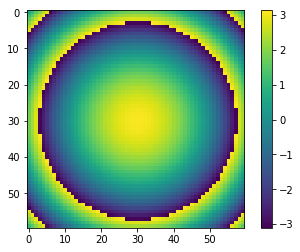

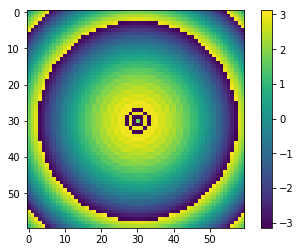

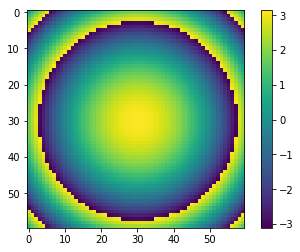

In [16]:
phin1 = (np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)).reshape((Nx, Ny))
angs1 = np.angle(phin1)
angs2 = np.angle(np.exp(1j * np.pi) * np.exp(-1j * np.pi * 1e-2 / wavelength * (xs**2 + ys**2) / Rs**2)).reshape((Nx, Ny))
angs3 = -np.angle(us).reshape(Nx, Ny)
plt.imshow(angs1)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()
plt.imshow(angs2)
plt.colorbar()
plt.show()

In [16]:
qs_abs = cbc.utils.q_abs(kouts, kins) / 2.0 / wavelength / 1e7
asf_coeffs1 = cbc.asf_coeffs()
%time asfs1 = cbc.asf_vals(qs_abs, asf_coeffs1)
qs_abs.shape

CPU times: user 667 ms, sys: 5.18 ms, total: 672 ms
Wall time: 672 ms


(4096, 3600)

In [13]:
ss = cbc.utils.qs(kouts, kins) / 2.0 / wavelength / 1e7
asf_coeffs1, xs1, ys1, zs1, bs1 = cbc.pdb_import('4et8.pdb', wavelength)
%time sfs1 = cbc.sf_vals(ss, asf_coeffs1, xs1, ys1, zs1, bs1)
ss.shape

CPU times: user 7.2 ms, sys: 5 µs, total: 7.2 ms
Wall time: 7.21 ms


(4096, 3600, 3)

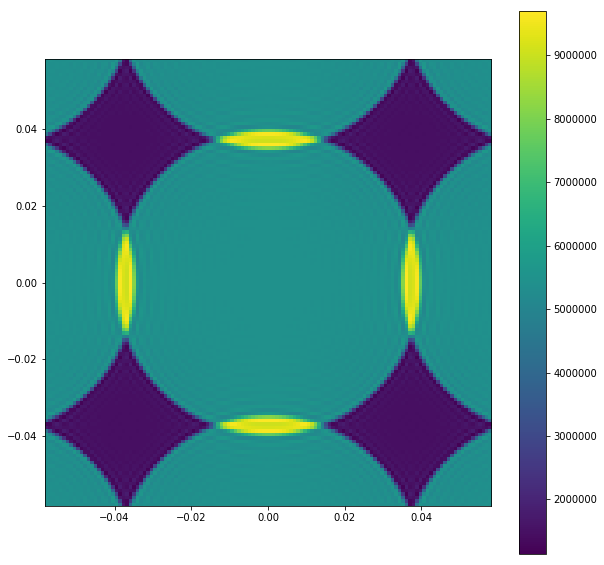

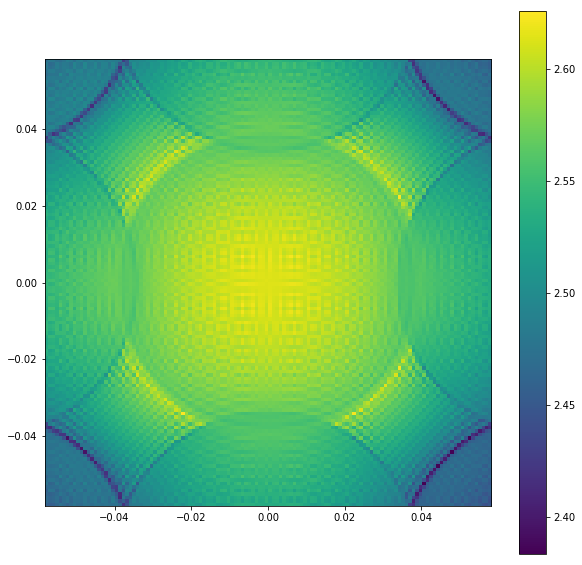

In [199]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=-1).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

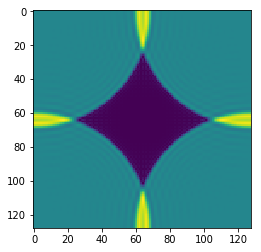

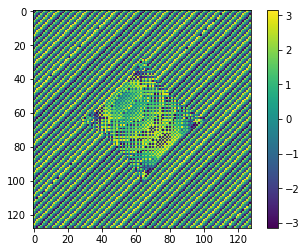

In [200]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()

In [12]:
import concurrent.futures
from functools import partial

In [30]:
class worker_star(object):
    def __init__(self, worker):
        self.worker = worker
    
    def __call__(self, args):
        return self.worker(*args)
    
def cbeam_pool(thread_num, xs, ys, zs, f, ap, wavelength):
    worker = partial(cbeam, f=f, a=ap, wavelength=wavelength)
    us = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for u in executor.map(worker_star(worker), zip(np.array_split(xs, thread_num), np.array_split(ys, thread_num), np.array_split(zs, thread_num))):
            us.extend(u)
    return np.array(us)

In [27]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
%timeit cbeam_pool(100, xs, ys, zs, f, ap, wavelength)
%timeit cbeam(xs, ys, zs, f, ap, wavelength)

361 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.28 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
us1 = cbeam_pool(100, xs, ys, zs, f, ap, wavelength)
us2 = cbeam(xs, ys, zs, f, ap, wavelength)
print(us1[:2], us2[:2])

[ 13.15570762+13.18744925j -16.69769044-16.60112075j] [ 13.15570762+13.18744925j -16.69769044-16.60112075j]
